In [11]:
import nipype.pipeline.engine as pe

from nipype.interfaces import ants
from nipype.interfaces import io as nio
from nipype.interfaces import utility as util
from nipype.interfaces import fsl

In [6]:
templates = {'epi2t1weighted':'/home/gdholla1/projects/bias/data/derivatives/registration/epi2t1weighted/epi2structmat_ants/_subject_id_{subject_id}/transformComposite.h5',
             't1weighted2mni':'/home/gdholla1/projects/bias/data/derivatives/registration/epi2t1weighted/struct2mnimat_ants/_subject_id_{subject_id}/transformComposite.h5',
             'mean_epi':'/home/gdholla1/projects/bias/data/processed/feat_preprocess/mean/_subject_id_{subject_id}/_fwhm_0.0/sub-{subject_id}_task-randomdotmotion_run-01_bold_unwarped_st_dtype_mcf_mask_gms_mean.nii.gz',}

In [17]:
workflow = pe.Workflow(name='epi2mni_check')
workflow.base_dir = '/home/gdholla1/projects/bias/workflow_folders/'

selector = pe.Node(nio.SelectFiles(templates), name='selector')

subject_ids = ['%02d' % i for i in xrange(1, 20)]
selector.iterables = [('subject_id', subject_ids)]

merger = pe.Node(util.Merge(2), name='merger')
workflow.connect(selector, 't1weighted2mni', merger, 'in1')
workflow.connect(selector, 'epi2t1weighted', merger, 'in2')


transformer = pe.Node(ants.ApplyTransforms(), name='transformer')
transformer.inputs.reference_image = fsl.Info.standard_image('MNI152_T1_1mm_brain.nii.gz')
workflow.connect(merger, 'out', transformer, 'transforms')

workflow.connect(selector, 'mean_epi', transformer, 'input_image')

ds = pe.Node(nio.DataSink(), name='datasink')
ds.inputs.base_directory = '/home/gdholla1/projects/bias/data/derivatives/registration/'

workflow.connect(transformer, 'output_image', ds, 'mean_epi_in_mni152')

workflow.run()

In [18]:
import nibabel as nb

import scipy as sp
from scipy import ndimage

In [158]:
subject_id = '01'

fn1 = '/home/gdholla1/projects/bias/data/processed/feat_preprocess/mean/_subject_id_{subject_id}/_fwhm_0.0/sub-{subject_id}_task-randomdotmotion_run-01_bold_unwarped_st_dtype_mcf_mask_gms_mean.nii.gz'.format(**locals())

subject_id = '02'
fn2 = '/home/gdholla1/projects/bias/data/processed/feat_preprocess/mean/_subject_id_{subject_id}/_fwhm_0.0/sub-{subject_id}_task-randomdotmotion_run-01_bold_unwarped_st_dtype_mcf_mask_gms_mean.nii.gz'.format(**locals())

In [163]:
fn2

'/home/gdholla1/projects/bias/data/processed/feat_preprocess/mean/_subject_id_02/_fwhm_0.0/sub-02_task-randomdotmotion_run-01_bold_unwarped_st_dtype_mcf_mask_gms_mean.nii.gz'

In [160]:
(nb.load(fn1).get_data() == nb.load(fn2).get_data()).all()

False

In [140]:
mni = nb.load(fsl.Info.standard_image('MNI152_T1_1mm_brain.nii.gz'))



In [142]:
sns.set_context('poster')

In [153]:
subj_idx = '01'
a = nb.load('/home/gdholla1/projects/bias/data/derivatives/registration/mean_epi_in_mni152/_subject_id_{}/sub-{}_task-randomdotmotion_run-01_bold_unwarped_st_dtype_mcf_mask_gms_mean_trans.nii.gz'.format(subj_idx, subj_idx))

subj_id = '02'
b = nb.load('/home/gdholla1/projects/bias/data/derivatives/registration/mean_epi_in_mni152/_subject_id_{}/sub-{}_task-randomdotmotion_run-01_bold_unwarped_st_dtype_mcf_mask_gms_mean_trans.nii.gz'.format(subj_idx, subj_idx))

In [155]:
(a.get_data() == b.get_data()).all()

True

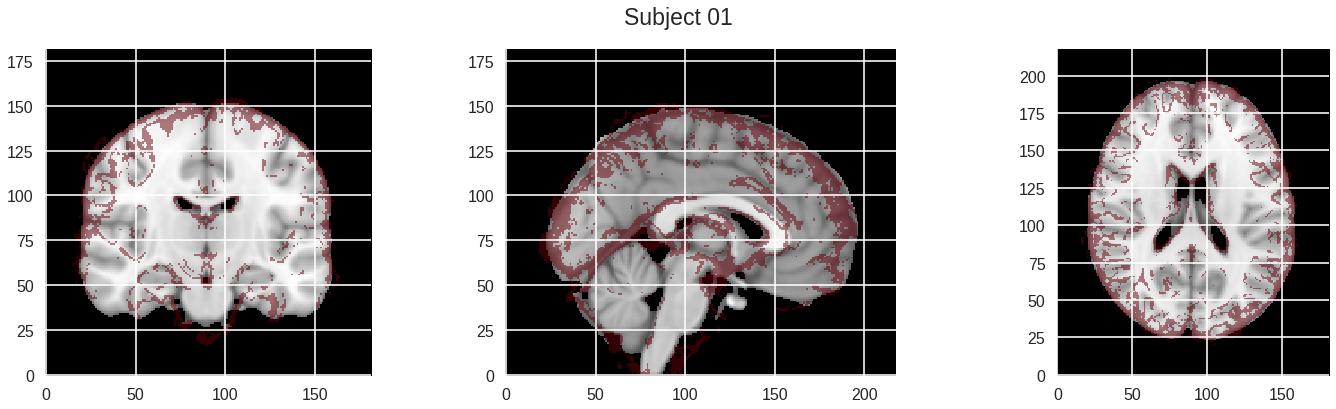

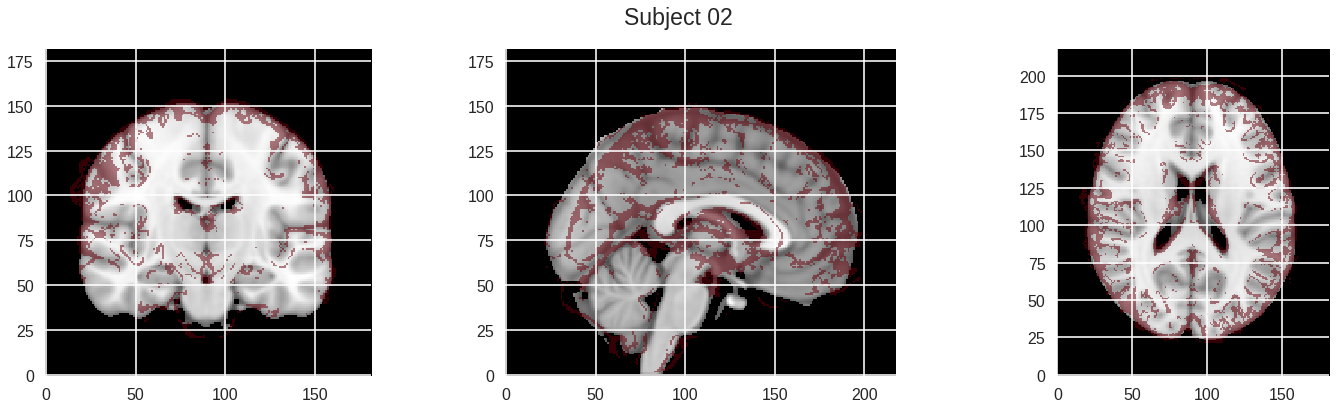

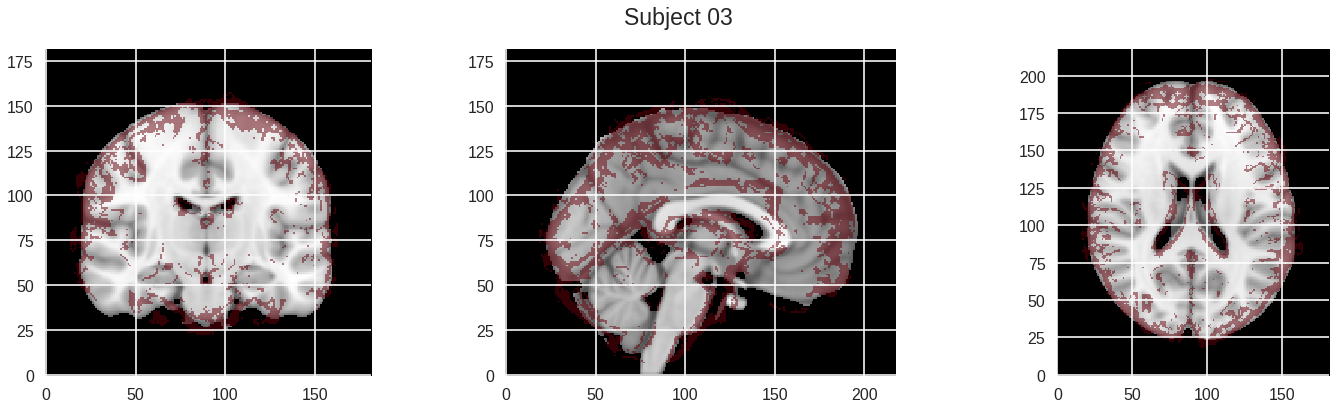

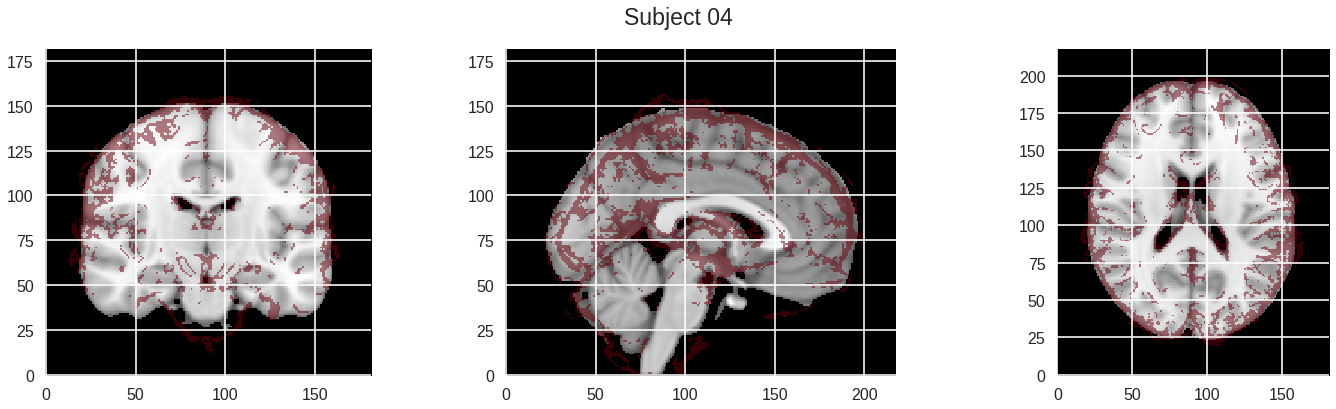

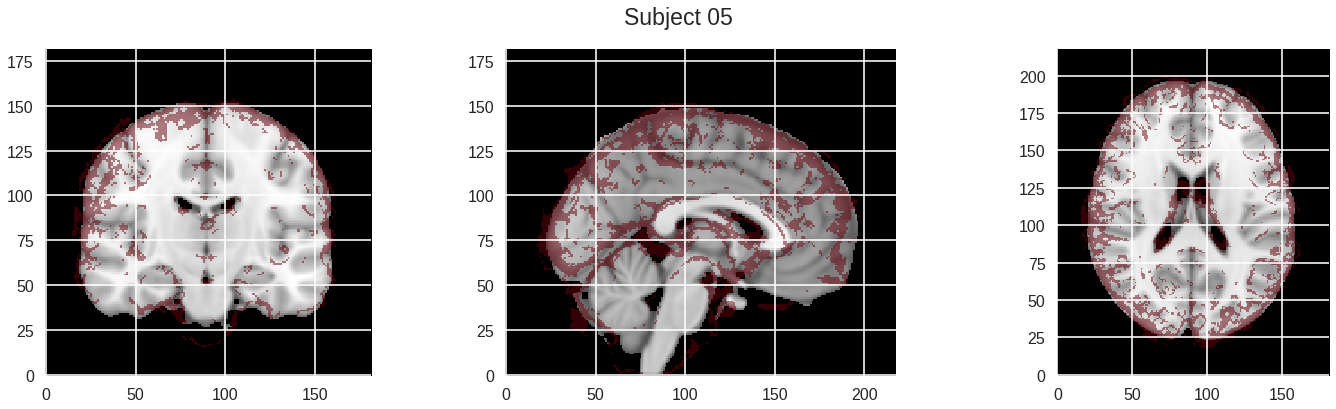

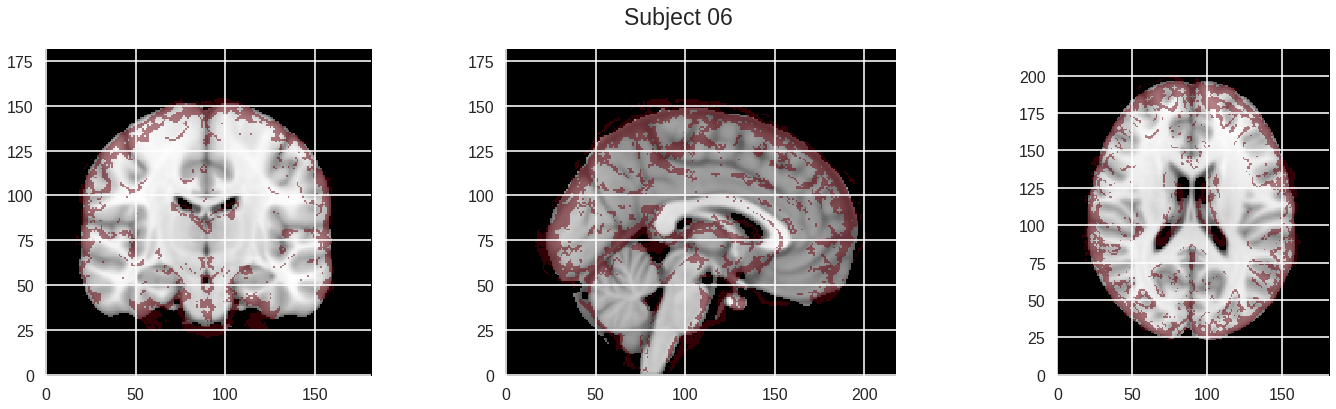

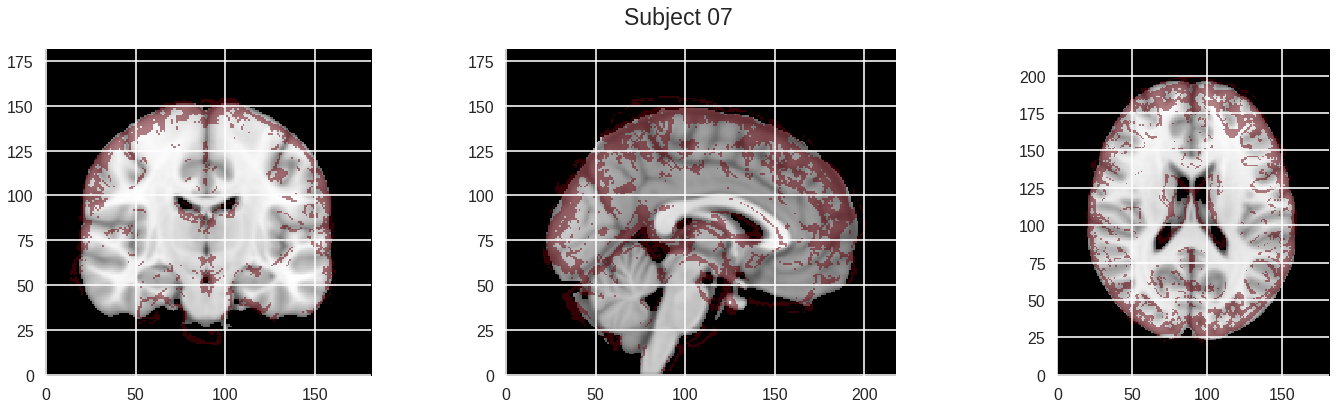

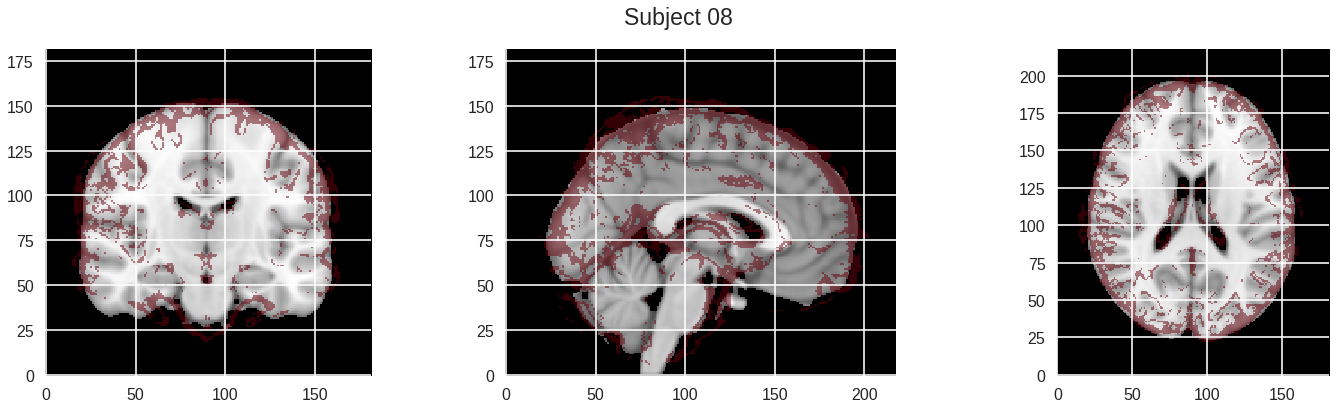

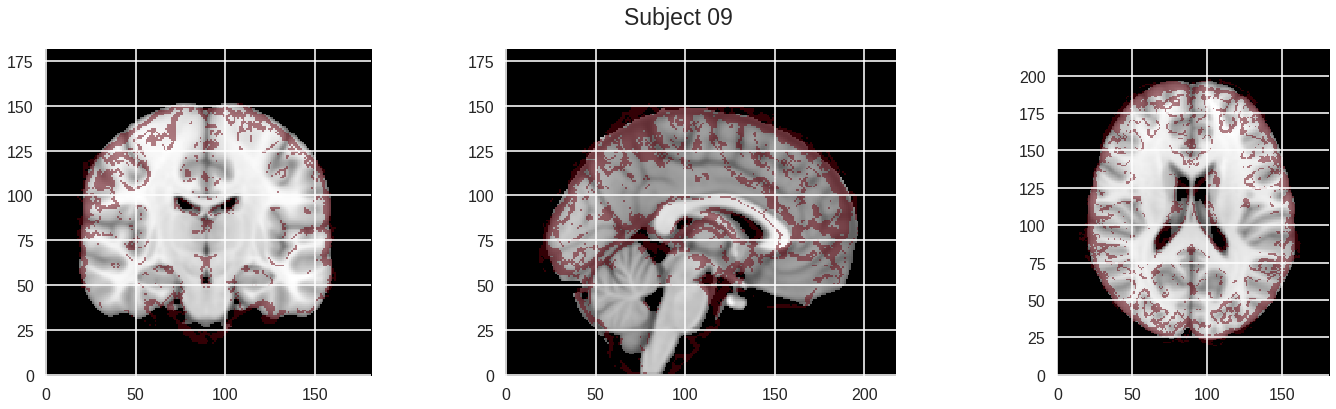

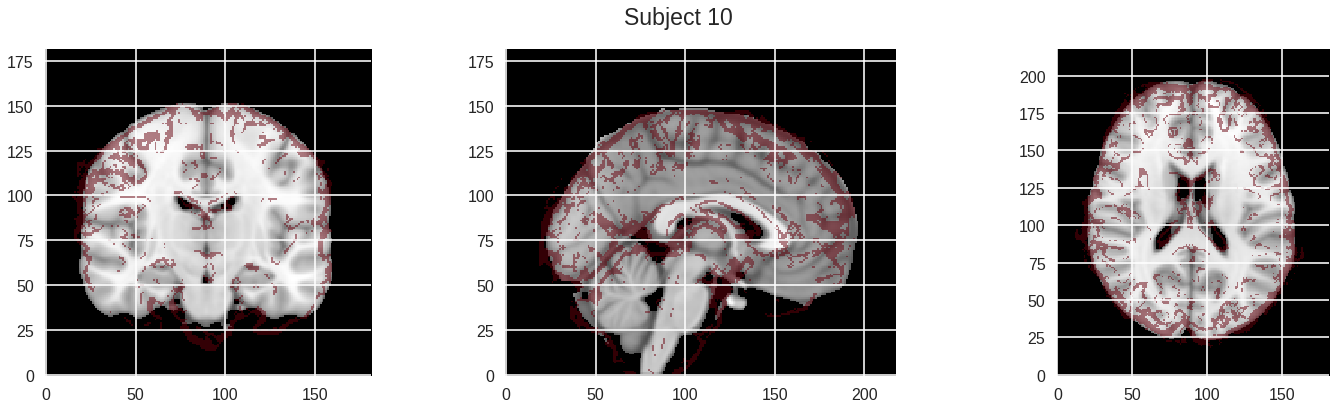

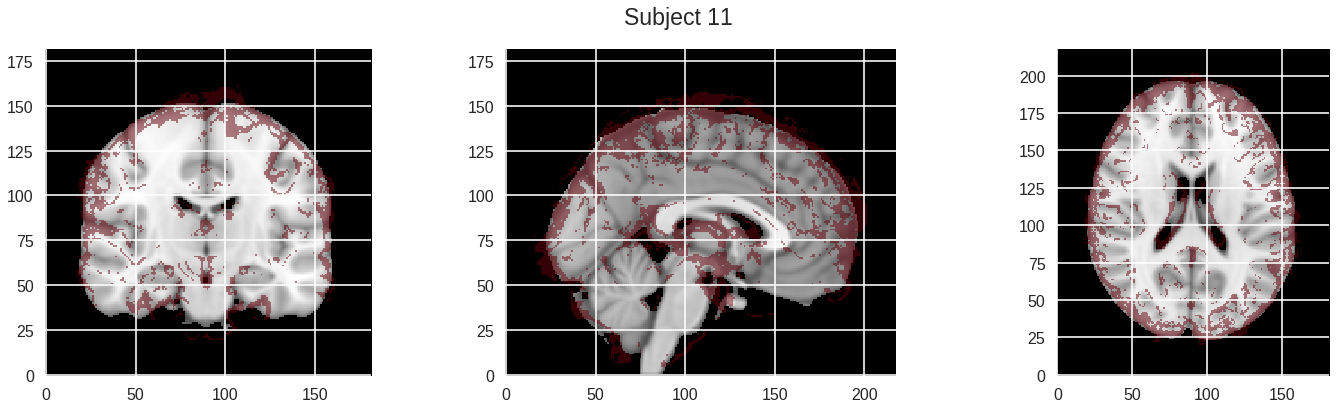

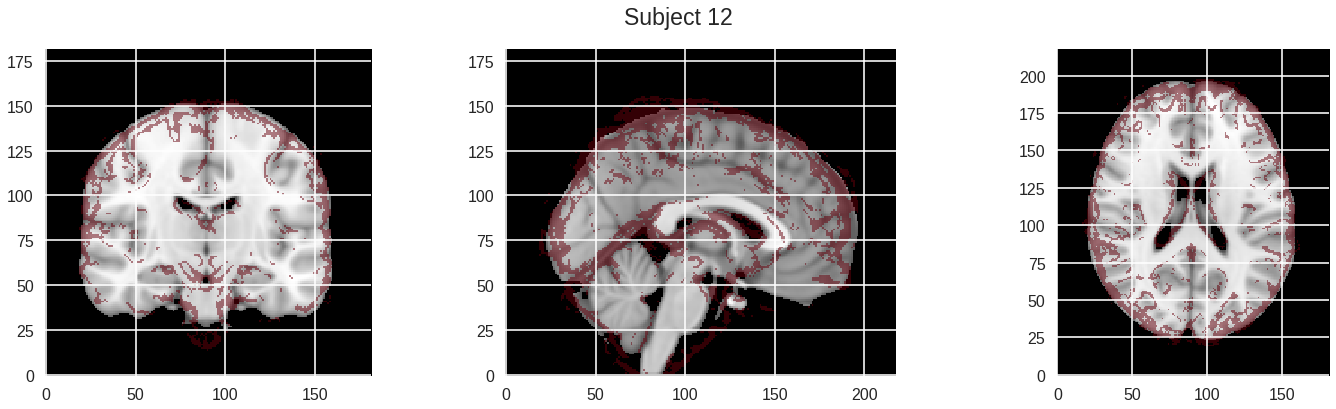

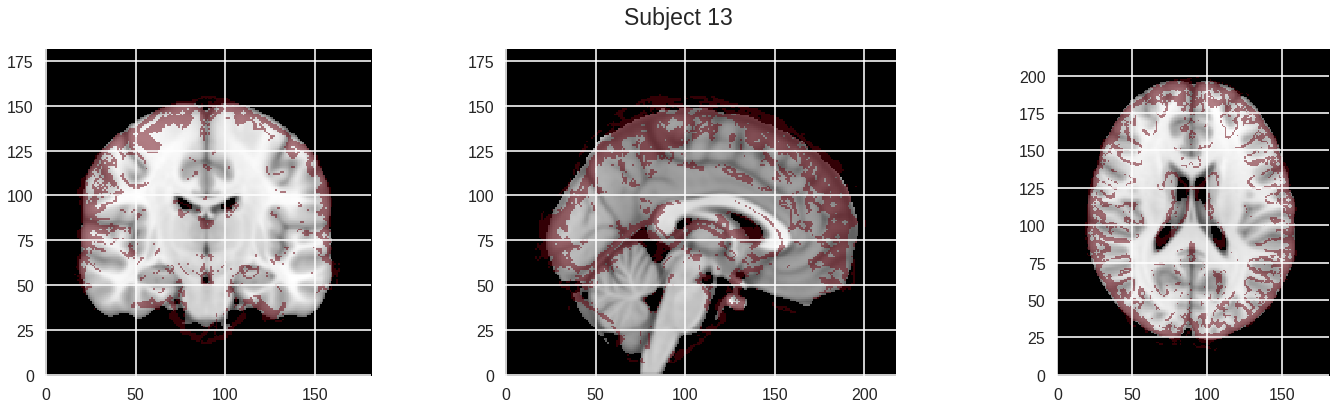

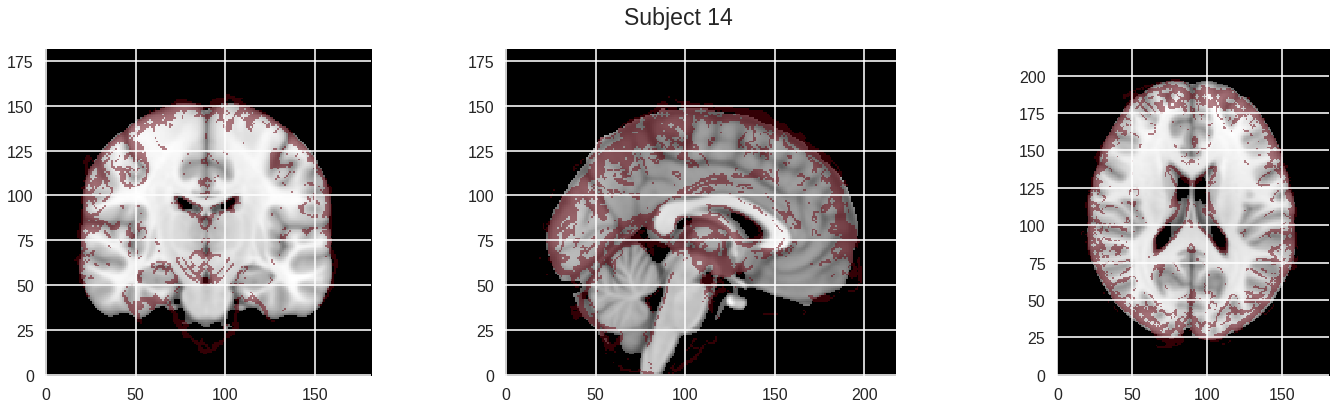

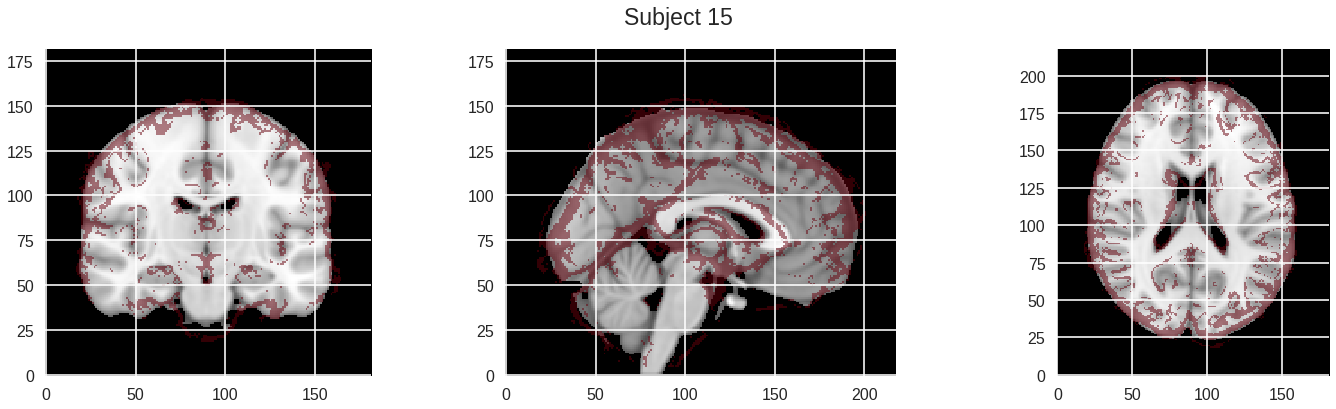

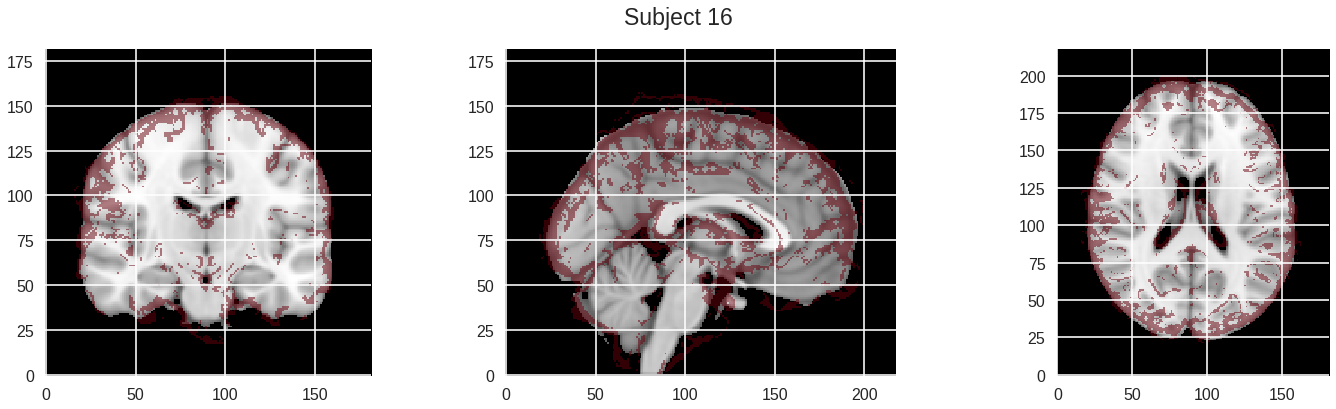

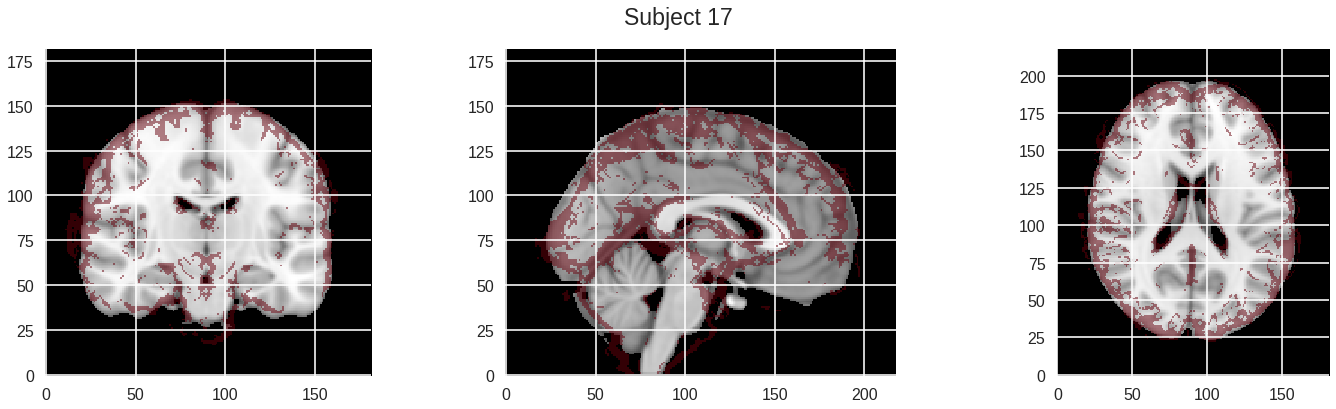

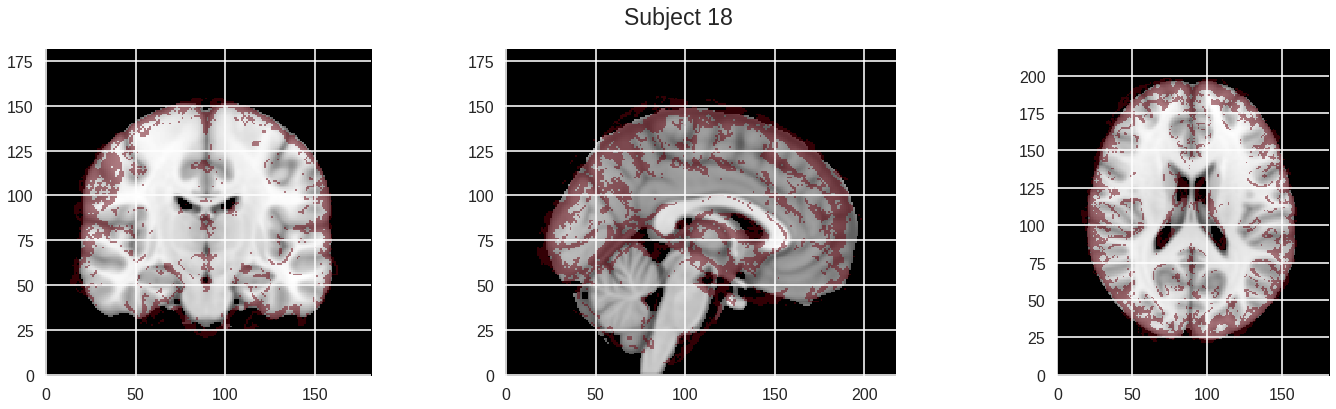

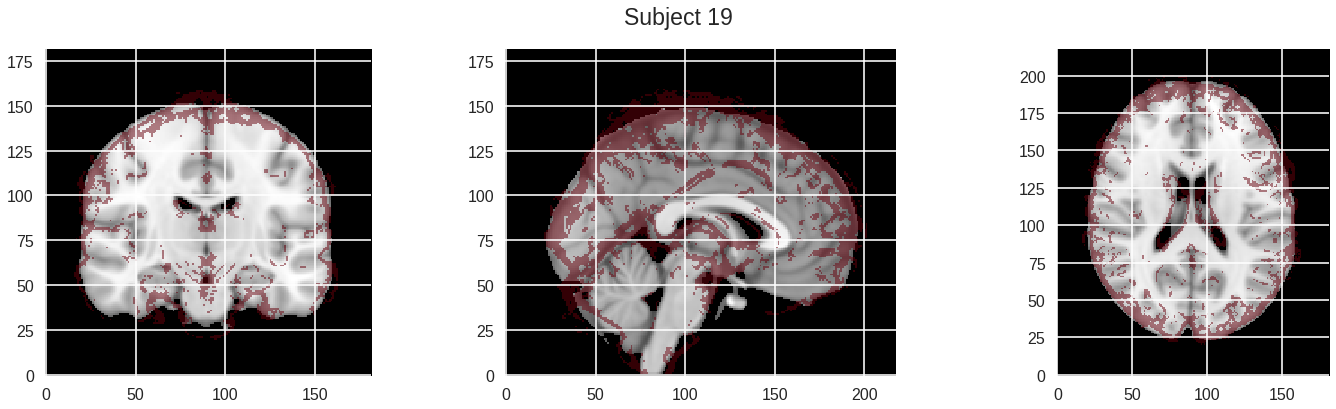

In [167]:


for subj_idx in ['%02d' % i for i in range(1, 20)]:
    epi_in_mni = nb.load('/home/gdholla1/projects/bias/data/derivatives/registration/mean_epi_in_mni152/_subject_id_{}/sub-{}_task-randomdotmotion_run-01_bold_unwarped_st_dtype_mcf_mask_gms_mean_trans.nii.gz'.format(subj_idx, subj_idx))
    
#     print epi_in_mni.get_data().sum()

    gradient = np.gradient(epi_in_mni.get_data())
    gradient_size = np.sum(np.array(gradient)**2, 0)

    gradient_size = np.ma.masked_less(gradient_size, np.percentile(gradient_size, 85))
    
    gradient_size.mask = ~ndimage.binary_erosion(~gradient_size.mask, iterations=1)
    
    plt.figure()
    plt.subplot(131)

    plt.imshow(mni.get_data()[:, 218/2, :].T, origin='lower', cmap=plt.cm.gray)
    plt.imshow(gradient_size[:, 218/2, :].T, origin='lower', cmap=plt.cm.Reds, vmin=0, vmax=1., alpha=0.5)

    plt.subplot(132)

    plt.imshow(mni.get_data()[182/2, :, :].T, origin='lower', cmap=plt.cm.gray)
    plt.imshow(gradient_size[182/2, :, :].T, origin='lower', cmap=plt.cm.Reds, vmin=0, vmax=1., alpha=0.5)

    plt.subplot(133)

    plt.imshow(mni.get_data()[..., 182/2].T, origin='lower', cmap=plt.cm.gray)
    plt.imshow(gradient_size[..., 182/2].T, origin='lower', cmap=plt.cm.Reds, vmin=0, vmax=1., alpha=0.5)

    plt.gcf().set_size_inches(25, 6)
    plt.suptitle('Subject %s' % subj_idx)